# Day 6: Homework


Day 6 exercise part 1:

Design a basic autoencoder for image compression. Consider a dataset of grayscale images with dimensions 28x28 pixels. Your autoencoder should have a bottleneck layer with 64 neurons.

1. Define the architecture of your autoencoder, including the number of layers, type of layers, and activation functions used.
2. Explain how the autoencoder can be trained to reconstruct images while compressing them.
3. Discuss potential applications of autoencoders in image processing beyond compression.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_trasnform = transforms.ToTensor()

In [3]:
dataset = torchvision.datasets.MNIST('./root' , transform = data_trasnform , download = True , train = True)
testset = torchvision.datasets.MNIST('./root' , transform = data_trasnform , download = True , train = False)

100%|██████████| 9912422/9912422 [00:00<00:00, 151689669.02it/s]

Extracting ./root/MNIST/raw/train-images-idx3-ubyte.gz to ./root/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39573895.40it/s]


Extracting ./root/MNIST/raw/train-labels-idx1-ubyte.gz to ./root/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 50348289.52it/s]

Extracting ./root/MNIST/raw/t10k-images-idx3-ubyte.gz to ./root/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20202045.35it/s]


Extracting ./root/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./root/MNIST/raw



In [4]:

batchsize   = 25
num_workers = 0

In [5]:

trainloader = DataLoader(dataset , shuffle = True , batch_size = batchsize , num_workers = num_workers)
testloader  = DataLoader(testset , shuffle = True , batch_size = batchsize , num_workers = num_workers)

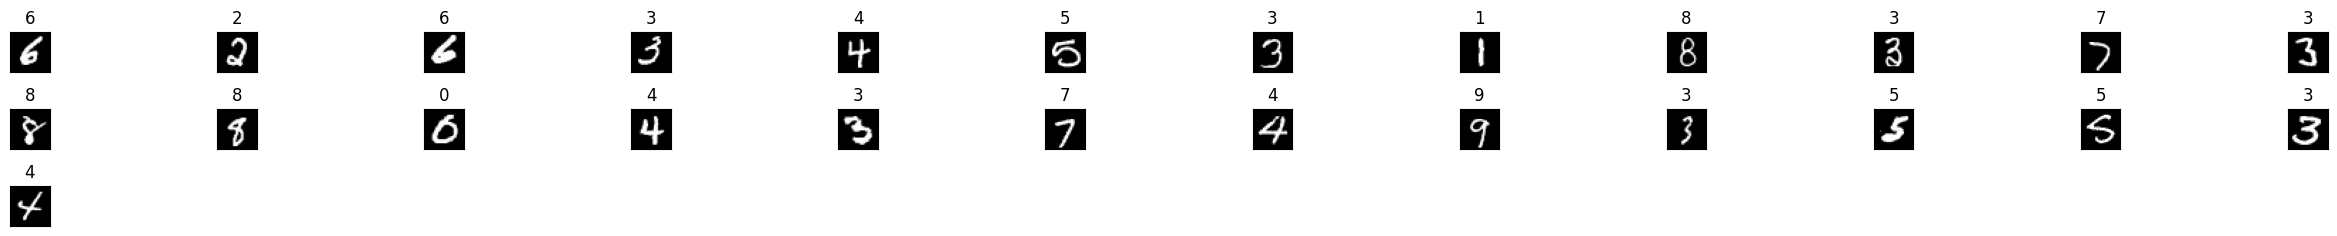

In [6]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(iter(trainloader))
images = images.numpy()
fig = plt.figure(figsize=(25, 4))

for i in range(batchsize):
    ax = fig.add_subplot(5, batchsize // 2, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[i]), cmap='gray')
    ax.set_title(labels[i].item())

plt.tight_layout()
plt.show()


In [7]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(64, 8, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)

        ## decoder layers ##
        self.t_conv1 = nn.ConvTranspose2d(8, 64, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(64, 1, 2, stride=2)


    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        ## decode ##
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))

        return x

# initialize the NN
model = ConvAutoencoder().cuda()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 64, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [8]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:

# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train(n_epochs , model):
  training_loss = []

  for epoch in range(n_epochs):
    trainloss = 0.0
    for batch_i , (images , labels) in enumerate(trainloader):
      optimizer.zero_grad()
      output = model(images.cuda())
      loss = criterion(output , images.cuda())
      loss.backward()
      optimizer.step()
      trainloss += loss.item()
    print("Epoch: {} , Batch: {} , Training Loss: {}".format(epoch + 1 , batch_i + 1 , trainloss / len(trainloader)))
    training_loss.append(trainloss)

  print("Training Completed !!!")

In [10]:
train(5 , model)

Epoch: 1 , Batch: 2400 , Training Loss: 0.014229489086816708
Epoch: 2 , Batch: 2400 , Training Loss: 0.005977425889286678
Epoch: 3 , Batch: 2400 , Training Loss: 0.00496462074011409
Epoch: 4 , Batch: 2400 , Training Loss: 0.004473076075082644
Epoch: 5 , Batch: 2400 , Training Loss: 0.004238669614423997
Training Completed !!!


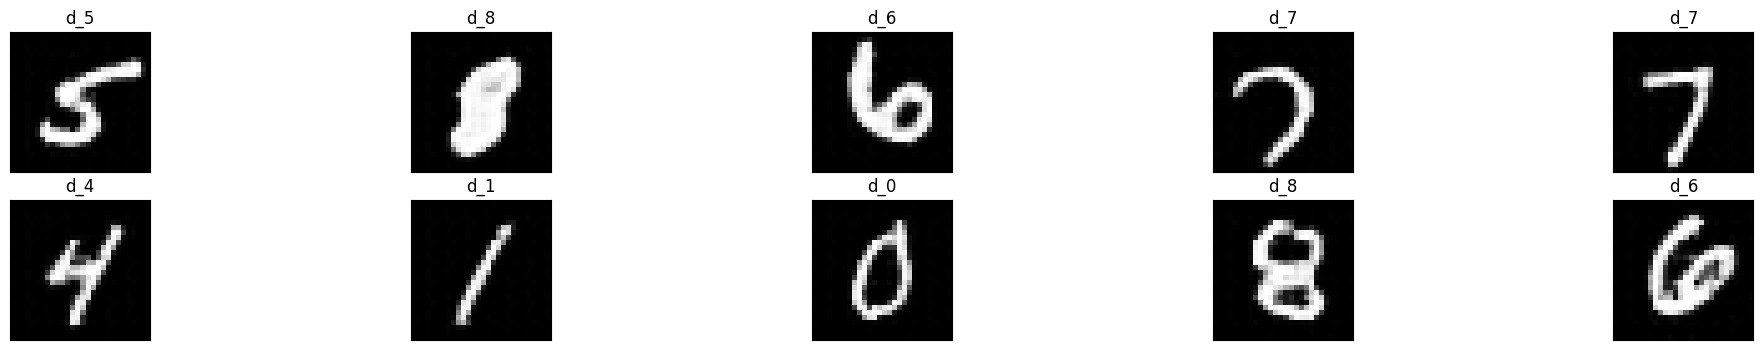

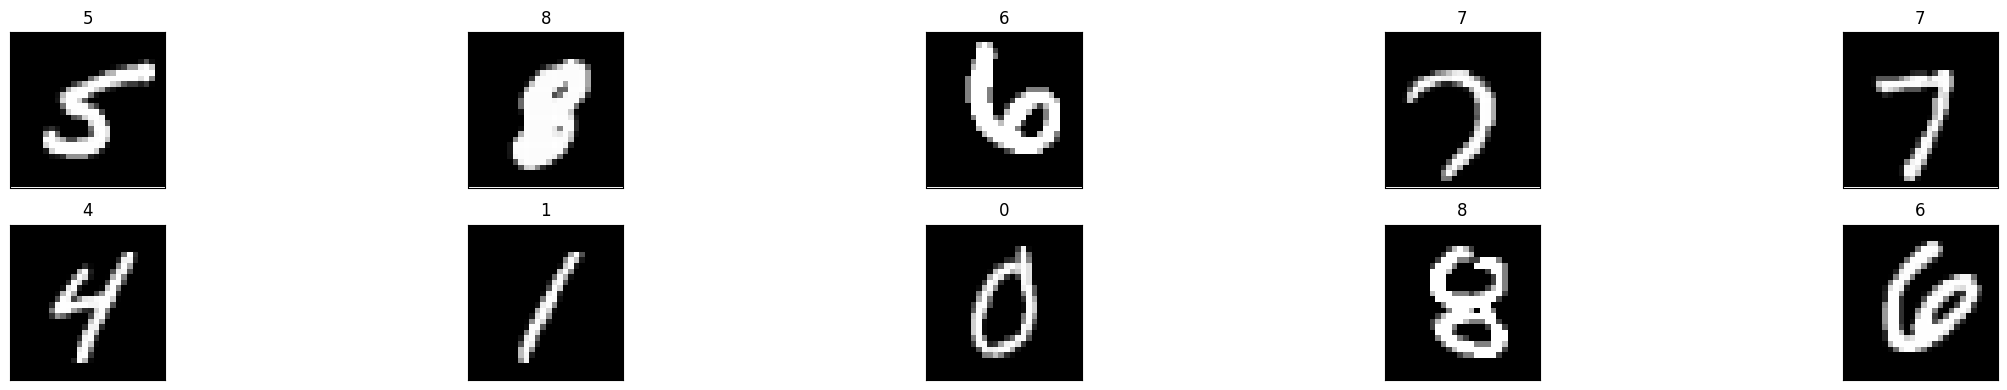

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(model, testloader, batchsize=10):
    images, labels = next(iter(testloader))
    preds = model(images.cuda()).view(-1, 28, 28).cpu()
    images = images.numpy()

    fig1 = plt.figure(figsize=(25, 4))
    fig2 = plt.figure(figsize=(25, 4))

    for i in range(batchsize):
        ax1 = fig2.add_subplot(2, batchsize // 2, i + 1, xticks=[], yticks=[])
        ax1.imshow(np.squeeze(images[i]), cmap='gray')
        ax1.set_title(labels[i].item())

    for i in range(batchsize):
        ax = fig1.add_subplot(2, batchsize // 2, i + 1, xticks=[], yticks=[])
        ax.imshow(preds[i].detach().numpy().reshape(28, 28), cmap='gray')
        ax.set_title("d_" + str(labels[i].item()))

    plt.tight_layout()
    plt.show()

# Now you can call the function with your model and testloader
plot_images(model, testloader)


# Homework

Day 6 exercise part 2:

- Design an autoencoder for image denoising using Python and a dataset of grayscale images with dimensions 64x64 pixels.
- Describe the architecture of your denoising autoencoder including the number of layers, type of layers, and activation functions used.
- Show how the autoencoder has been trained to remove noise from images while preserving important features.

In [12]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as f

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [13]:
data_transform = transforms.ToTensor()


In [14]:
dataset = torchvision.datasets.MNIST('./root',download=True,transform = data_transform,train=True)
testset = torchvision.datasets.MNIST('./root',download=True,transform = data_transform,train=False)

In [15]:
batchsize   = 20
numworkers = 0

In [16]:
trainloader = DataLoader(dataset , shuffle = True , batch_size = batchsize , num_workers = num_workers)
testloader  = DataLoader(testset , shuffle = True , batch_size = batchsize , num_workers = num_workers)

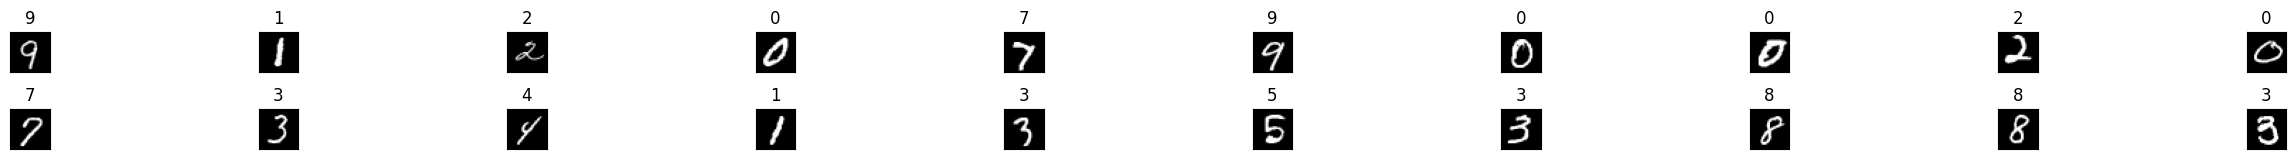

In [17]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(iter(trainloader))
images = images.numpy()
fig = plt.figure(figsize=(25, 4))

for i in range(batchsize):
    ax = fig.add_subplot(5, batchsize // 2, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[i]), cmap='gray')
    ax.set_title(labels[i].item())

plt.tight_layout()
plt.show()


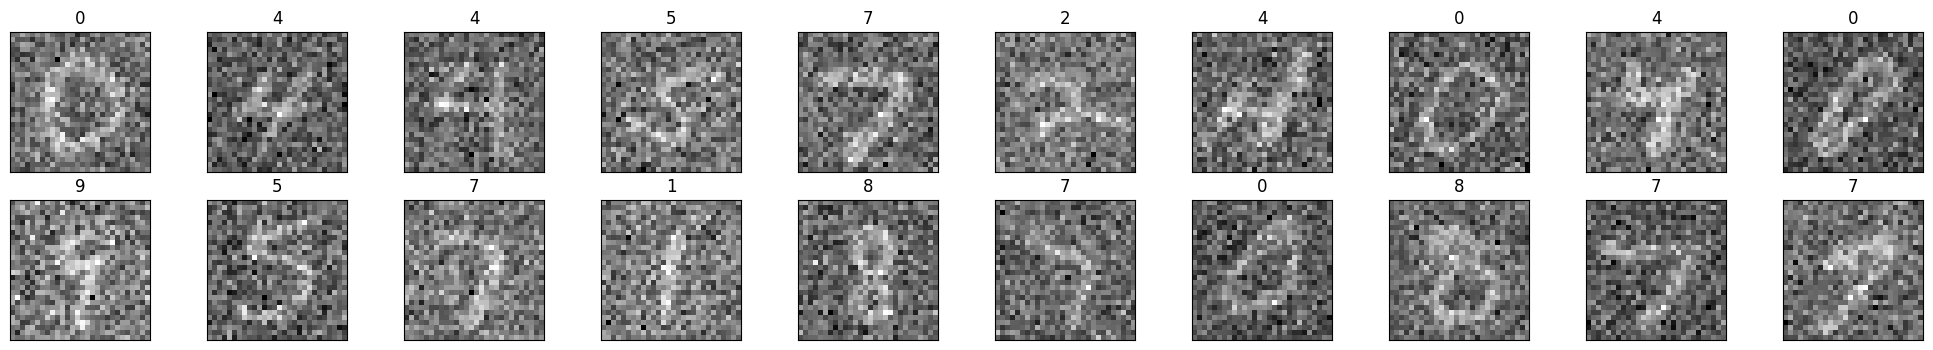

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of data from the trainloader
for images, labels in trainloader:
    images = images.numpy()
    break

noise_factor = 0.5
fig = plt.figure(figsize=(25, 4))

# Plotting images with noise
for i in range(batchsize):
    images_n = images[i] + np.random.randn(*images[i].shape) * noise_factor
    ax = fig.add_subplot(2, batchsize // 2, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images_n), cmap='gray')
    ax.set_title(labels[i].item())

plt.show()


In [19]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        ## decoder layers ##
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        # one, final, normal conv layer to decrease the depth
        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)


    def forward(self, x):
        ## encode ##
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # compressed representation

        ## decode ##
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = F.sigmoid(self.conv_out(x))

        return x

# initialize the NN
model = ConvDenoiser()
model.cuda()
print(model)

ConvDenoiser(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [20]:
# specify loss function
criterion = nn.MSELoss().cuda()
# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
noise_factor = 0.5
n_epochs = 10
trainloss = []

for epoch in range(n_epochs):
  train_loss = 0.0
  for batch_i , (images , target) in enumerate(trainloader):
    noisy_images = images + torch.randn(*images.shape) * noise_factor
    noisy_images = torch.tensor(noisy_images).cuda()
    optimizer.zero_grad()
    output = model(noisy_images)
    loss = criterion(output , images.cuda())
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  print("Epoch: {} , Batch: {} , Training Loss: {}".format(epoch + 1 , batch_i + 1 , train_loss / len(trainloader)))
  trainloss.append(train_loss / len(trainloader))

print("Training Completed !!!")


<ipython-input-21-d7e7b7b491b4>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_images = torch.tensor(noisy_images).cuda()


Epoch: 1 , Batch: 3000 , Training Loss: 0.04450278933718801
Epoch: 2 , Batch: 3000 , Training Loss: 0.027824709586799144
Epoch: 3 , Batch: 3000 , Training Loss: 0.024559584368020297
Epoch: 4 , Batch: 3000 , Training Loss: 0.023082943226521213
Epoch: 5 , Batch: 3000 , Training Loss: 0.022126596039781968
Epoch: 6 , Batch: 3000 , Training Loss: 0.02134858238666008
Epoch: 7 , Batch: 3000 , Training Loss: 0.020662367505952715
Epoch: 8 , Batch: 3000 , Training Loss: 0.020146924047109983
Epoch: 9 , Batch: 3000 , Training Loss: 0.019792455969378352
Epoch: 10 , Batch: 3000 , Training Loss: 0.019493071771226823
Training Completed !!!


<ipython-input-22-fa49d4b4074b>:14: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  preds = model(torch.cuda.FloatTensor(images_n).cuda()).cpu().detach().numpy()


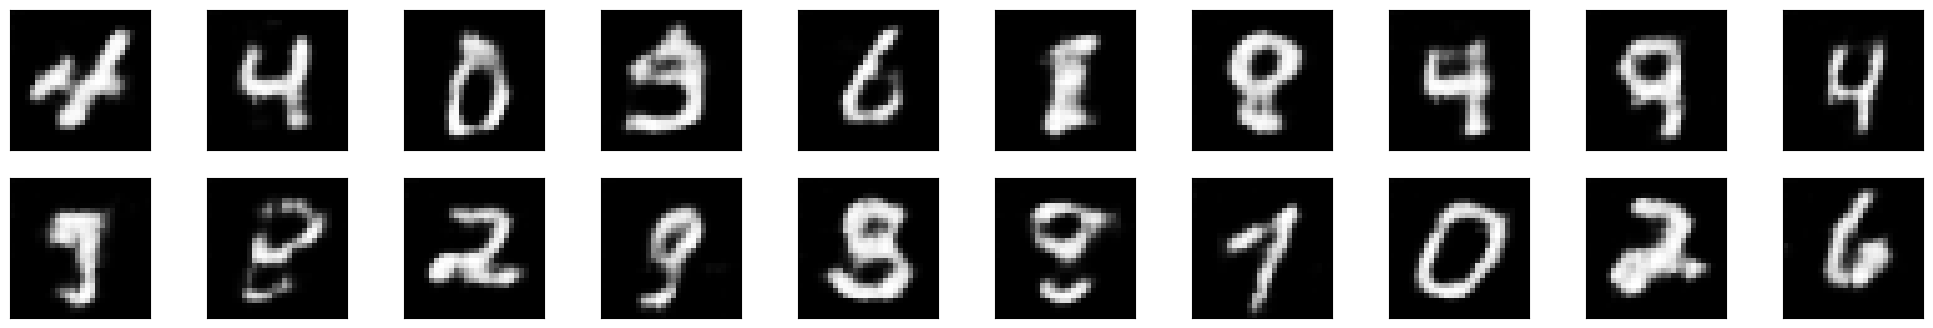

In [22]:
import matplotlib.pyplot as plt
import numpy as np


# Get a batch of data from the testloader
for images, labels in testloader:
    # Convert images to numpy array
    images = images.numpy()
    break

# Add noise to the images and make predictions
for i in range(batchsize):
    images_n = images + np.random.randn(*images.shape) * noise_factor
    preds = model(torch.cuda.FloatTensor(images_n).cuda()).cpu().detach().numpy()

# Plot the predicted images
fig = plt.figure(figsize=(25, 4))
for i in range(batchsize):
    ax = fig.add_subplot(2, batchsize // 2, i + 1, xticks=[], yticks=[])
    ax.imshow(preds[i].reshape(28, 28), cmap='gray')

plt.show()


# Homework

- Day 7 part 1 exercise: (in contd to the Day 6 part 2 exercise)
- train the model for epochs: 10, 20, 35, 50)
- observe the summary of the model: change the dimension of the NN

# epochs 20

In [23]:
noise_factor = 0.5
n_epochs = 20
trainloss = []

for epoch in range(n_epochs):
  train_loss = 0.0
  for batch_i , (images , target) in enumerate(trainloader):
    noisy_images = images + torch.randn(*images.shape) * noise_factor
    noisy_images = torch.tensor(noisy_images).cuda()
    optimizer.zero_grad()
    output = model(noisy_images)
    loss = criterion(output , images.cuda())
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  print("Epoch: {} , Batch: {} , Training Loss: {}".format(epoch + 1 , batch_i + 1 , train_loss / len(trainloader)))
  trainloss.append(train_loss / len(trainloader))

print("Training Completed !!!")




<ipython-input-23-7e69c01d9846>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_images = torch.tensor(noisy_images).cuda()


Epoch: 1 , Batch: 3000 , Training Loss: 0.01922365389733265
Epoch: 2 , Batch: 3000 , Training Loss: 0.018933152300616107
Epoch: 3 , Batch: 3000 , Training Loss: 0.018754008552059533
Epoch: 4 , Batch: 3000 , Training Loss: 0.018569147313324114
Epoch: 5 , Batch: 3000 , Training Loss: 0.01842674565097938
Epoch: 6 , Batch: 3000 , Training Loss: 0.018294141350624463
Epoch: 7 , Batch: 3000 , Training Loss: 0.018177334342462322
Epoch: 8 , Batch: 3000 , Training Loss: 0.018083338028751315
Epoch: 9 , Batch: 3000 , Training Loss: 0.018007613013808925
Epoch: 10 , Batch: 3000 , Training Loss: 0.017912488995119928
Epoch: 11 , Batch: 3000 , Training Loss: 0.01787595890555531
Epoch: 12 , Batch: 3000 , Training Loss: 0.01777583797524373
Epoch: 13 , Batch: 3000 , Training Loss: 0.01773076197132468
Epoch: 14 , Batch: 3000 , Training Loss: 0.017709801516185203
Epoch: 15 , Batch: 3000 , Training Loss: 0.01763669642371436
Epoch: 16 , Batch: 3000 , Training Loss: 0.01758614002292355
Epoch: 17 , Batch: 3000 

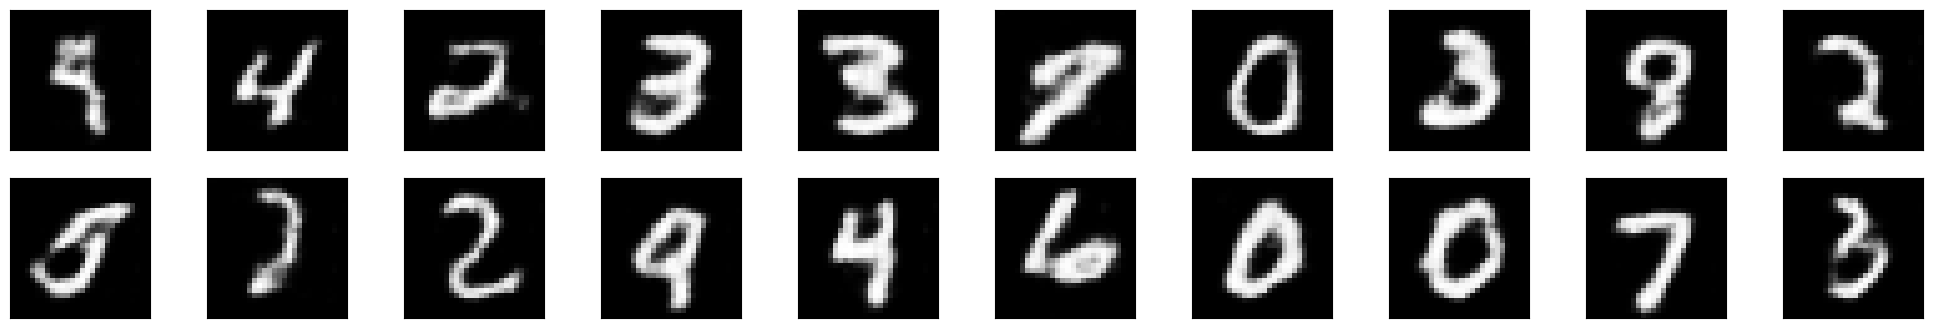

In [24]:
import matplotlib.pyplot as plt
import numpy as np


# Get a batch of data from the testloader
for images, labels in testloader:
    # Convert images to numpy array
    images = images.numpy()
    break

# Add noise to the images and make predictions
for i in range(batchsize):
    images_n = images + np.random.randn(*images.shape) * noise_factor
    preds = model(torch.cuda.FloatTensor(images_n).cuda()).cpu().detach().numpy()

# Plot the predicted images
fig = plt.figure(figsize=(25, 4))
for i in range(batchsize):
    ax = fig.add_subplot(2, batchsize // 2, i + 1, xticks=[], yticks=[])
    ax.imshow(preds[i].reshape(28, 28), cmap='gray')

plt.show()


# epochs 35

In [25]:
noise_factor = 0.5
n_epochs = 35
trainloss = []

for epoch in range(n_epochs):
  train_loss = 0.0
  for batch_i , (images , target) in enumerate(trainloader):
    noisy_images = images + torch.randn(*images.shape) * noise_factor
    noisy_images = torch.tensor(noisy_images).cuda()
    optimizer.zero_grad()
    output = model(noisy_images)
    loss = criterion(output , images.cuda())
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  print("Epoch: {} , Batch: {} , Training Loss: {}".format(epoch + 1 , batch_i + 1 , train_loss / len(trainloader)))
  trainloss.append(train_loss / len(trainloader))

print("Training Completed !!!")




<ipython-input-25-edd5159603ff>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_images = torch.tensor(noisy_images).cuda()


Epoch: 1 , Batch: 3000 , Training Loss: 0.017377655123360456
Epoch: 2 , Batch: 3000 , Training Loss: 0.017390233751386402
Epoch: 3 , Batch: 3000 , Training Loss: 0.01736705905664712
Epoch: 4 , Batch: 3000 , Training Loss: 0.017321015962709983
Epoch: 5 , Batch: 3000 , Training Loss: 0.01727745268121362
Epoch: 6 , Batch: 3000 , Training Loss: 0.017280681867773335
Epoch: 7 , Batch: 3000 , Training Loss: 0.017255372675446173
Epoch: 8 , Batch: 3000 , Training Loss: 0.017247283893326918
Epoch: 9 , Batch: 3000 , Training Loss: 0.017231977536032596
Epoch: 10 , Batch: 3000 , Training Loss: 0.017188313704915345
Epoch: 11 , Batch: 3000 , Training Loss: 0.017180218960158526
Epoch: 12 , Batch: 3000 , Training Loss: 0.017121652389255664
Epoch: 13 , Batch: 3000 , Training Loss: 0.01711300120720019
Epoch: 14 , Batch: 3000 , Training Loss: 0.017113295876110594
Epoch: 15 , Batch: 3000 , Training Loss: 0.017071883587787547
Epoch: 16 , Batch: 3000 , Training Loss: 0.017081158995007475
Epoch: 17 , Batch: 3

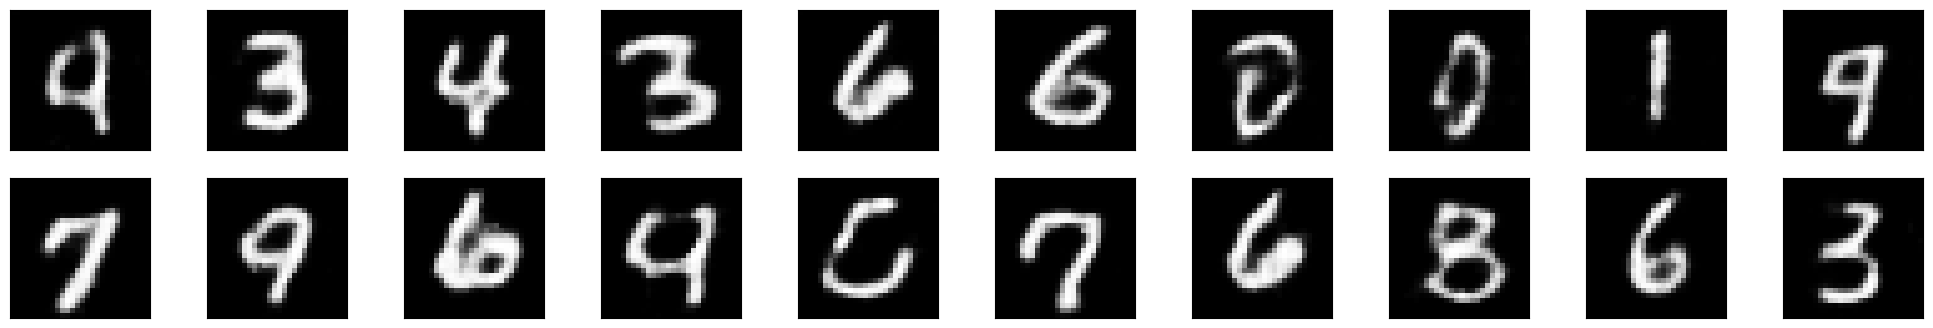

In [26]:
import matplotlib.pyplot as plt
import numpy as np


# Get a batch of data from the testloader
for images, labels in testloader:
    # Convert images to numpy array
    images = images.numpy()
    break

# Add noise to the images and make predictions
for i in range(batchsize):
    images_n = images + np.random.randn(*images.shape) * noise_factor
    preds = model(torch.cuda.FloatTensor(images_n).cuda()).cpu().detach().numpy()

# Plot the predicted images
fig = plt.figure(figsize=(25, 4))
for i in range(batchsize):
    ax = fig.add_subplot(2, batchsize // 2, i + 1, xticks=[], yticks=[])
    ax.imshow(preds[i].reshape(28, 28), cmap='gray')

plt.show()


# epochs 50

In [27]:
noise_factor = 0.5
n_epochs = 50
trainloss = []

for epoch in range(n_epochs):
  train_loss = 0.0
  for batch_i , (images , target) in enumerate(trainloader):
    noisy_images = images + torch.randn(*images.shape) * noise_factor
    noisy_images = torch.tensor(noisy_images).cuda()
    optimizer.zero_grad()
    output = model(noisy_images)
    loss = criterion(output , images.cuda())
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  print("Epoch: {} , Batch: {} , Training Loss: {}".format(epoch + 1 , batch_i + 1 , train_loss / len(trainloader)))
  trainloss.append(train_loss / len(trainloader))

print("Training Completed !!!")




<ipython-input-27-ca1aadc5a69a>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_images = torch.tensor(noisy_images).cuda()


Epoch: 1 , Batch: 3000 , Training Loss: 0.016743208841731153
Epoch: 2 , Batch: 3000 , Training Loss: 0.016712192051733535
Epoch: 3 , Batch: 3000 , Training Loss: 0.016706822535333534
Epoch: 4 , Batch: 3000 , Training Loss: 0.01667853061823795
Epoch: 5 , Batch: 3000 , Training Loss: 0.01667933420588573
Epoch: 6 , Batch: 3000 , Training Loss: 0.01665651080260674
Epoch: 7 , Batch: 3000 , Training Loss: 0.016674269882030784
Epoch: 8 , Batch: 3000 , Training Loss: 0.01662952585487316
Epoch: 9 , Batch: 3000 , Training Loss: 0.016644468620419503
Epoch: 10 , Batch: 3000 , Training Loss: 0.016621361769425372
Epoch: 11 , Batch: 3000 , Training Loss: 0.01664620144292712
Epoch: 12 , Batch: 3000 , Training Loss: 0.016602661264128984
Epoch: 13 , Batch: 3000 , Training Loss: 0.016599962552078067
Epoch: 14 , Batch: 3000 , Training Loss: 0.016601847821225722
Epoch: 15 , Batch: 3000 , Training Loss: 0.016585327787014346
Epoch: 16 , Batch: 3000 , Training Loss: 0.01658063778063903
Epoch: 17 , Batch: 3000

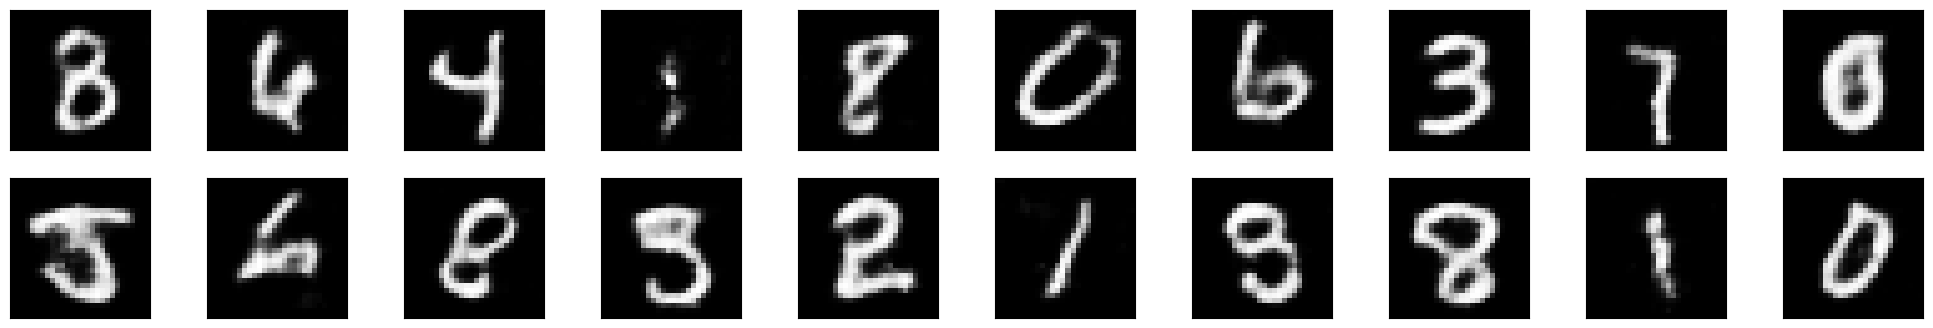

In [28]:
import matplotlib.pyplot as plt
import numpy as np


# Get a batch of data from the testloader
for images, labels in testloader:
    # Convert images to numpy array
    images = images.numpy()
    break

# Add noise to the images and make predictions
for i in range(batchsize):
    images_n = images + np.random.randn(*images.shape) * noise_factor
    preds = model(torch.cuda.FloatTensor(images_n).cuda()).cpu().detach().numpy()

# Plot the predicted images
fig = plt.figure(figsize=(25, 4))
for i in range(batchsize):
    ax = fig.add_subplot(2, batchsize // 2, i + 1, xticks=[], yticks=[])
    ax.imshow(preds[i].reshape(28, 28), cmap='gray')

plt.show()


# Conclusion:

1. Increased the epochs and train the model long its gives the good result